In [108]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from matplotlib import patches
from functools import reduce
import time
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output
import librosa
!pwd
from skimage.restoration import denoise_tv_bregman
from skimage import filters
from matplotlib import patches


/Users/raminanushiravani/Desktop/mouse_videos


In [82]:
disp = 0

In [83]:
save_path = "/Users/raminanushiravani/Desktop/mouse_videos/"
pathI = "/Users/raminanushiravani/Desktop/mouse_videos/injured/"
filesInj = os.listdir(pathI)
folInj = []
for file in filesInj:
    if '.avi' not in file:
        folInj.append(file)
        
pathH = "/Users/raminanushiravani/Desktop/mouse_videos/healthy/"
folHlt = []
filesHlt = os.listdir(pathH)
for file in filesHlt:
    if '.avi' not in file:
        folHlt.append(file)

In [84]:
healthy_frames = {}
for fol in folHlt:
    try:
        file = os.listdir(pathH + fol)
        healthy_target_filename = pathH + fol + '/' + file[0]
        framesH = [pathH + fol + '/frames/' + f for f in os.listdir(pathH + fol + '/frames')]
        healthy_frames[healthy_target_filename] = sorted(framesH, key = lambda x: (len(x.split('/')[-1]), x))

    except: 
        x = 0
        
injured_frames = {}

for fol in folInj:
    try:
        file = os.listdir(pathI + fol)
        injured_target_filename = pathI + fol + '/' + file[0]
        framesI = [pathI + fol + '/frames/' + f for f in os.listdir(pathI + fol + '/frames')]
        injured_frames[injured_target_filename] = sorted(framesI, key = lambda x: (len(x.split('/')[-1]), x))
    except: 
        x = 0 
        


In [85]:
from scipy import signal
from scipy.signal import argrelextrema

def extract_walking_frames(meanxs, offset):
    
    b, a = signal.butter(5, 0.2)
    y = signal.filtfilt(b, a, np.array(meanxs), padlen=10)
    plt.plot(y)

    local_max_idx = argrelextrema(y, np.greater)
    local_min_idx = argrelextrema(y, np.less)

    walking_frames = []
    for imin,imax in zip(local_min_idx[0],local_max_idx[0]):
        if abs(imax-imin)<10:
            walking_frames.append((min(imax+offset,imin+offset),max(imax+offset,imin+offset)))
    return walking_frames

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ni

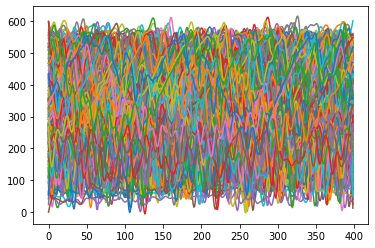

In [86]:
batch = []
images = []
dict_video = {}
walking_frames_videos = {}
offset = 400

for hi_frames in [healthy_frames,injured_frames]:
    
    for k in hi_frames.keys():
        
        walking_frames = []
        fname = k.split('image.')[0][0:-1]
        print(fname)
        names = hi_frames[k]
        sorted_names = sorted(names, key = lambda xx : int(xx.split('/')[-1].split('.')[0]))
        count = 0

        for frame_path in sorted_names:
            
            try:
                image_data = plt.imread(frame_path)
                image_data = np.int32(np.mean(image_data,axis = -1 ))
                batch.append(image_data)
            except:
                x = 1 
                
            print(len(batch),end='\r')
            
            if len(batch) >= offset:  
                o1 = offset * count
                count += 1 
                batch_arr = np.array(batch).squeeze()
                meanxs = [] 
                kk = 1
                count_index = 0
                diff_batch = batch_arr[0:-1,:,:] - batch_arr[1:,:,:] 
                for xx in diff_batch:
                    count_index += 1 
                    mean_x = np.mean(xx[:,0:600]>0,axis=0)
                    b, a = signal.butter(8, 0.025)
                    y = signal.filtfilt(b, a, np.array(mean_x), padlen=150)
                    meanxs.append(np.argmax(y))
                    if disp:
                        figure, ax = plt.subplots(2,2,figsize=(20,10))
                        ax[0][0].imshow(xx>0)
                        ax[0][1].imshow(batch_arr[count_index])
                        
                        
                        ax[1][0].plot(np.arange(kk),np.array(meanxs))
                        ax[1][1].plot(y)

                        kk += 1 
                        plt.show()
                        time.sleep(0.001) 
                        clear_output(wait=True)


                walking_frames.append(extract_walking_frames(meanxs,o1))
                batch = []
                
        walking_frames_videos[fname] = walking_frames 

pickle.dump(walking_frames_videos , open(save_path + 'walking_frames_all_videos.pickle','wb'))        


In [87]:

thr_merging = 30
thr_save = 50
def merge_frame_indicies(walking_frames,thr_merging):
    results = []
    count = 0 
    tuples = np.concatenate((walking_frames))

    for tuple_min_max in tuples:
        x = tuple_min_max[0]
        y = tuple_min_max[1]
        if count == 0:
            so_far = [x,y]
            count += 1
        else:
            if x - so_far[1] < thr_merging: 
                so_far[1] = y
            else:
                if so_far[1] - so_far[0] > thr_save:
                    results.append(so_far)
                count = 0
    return results

In [90]:
new_dict

{'/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP': [[11,
   223],
  [278, 436],
  [560, 794],
  [896, 999],
  [1100, 1295],
  [1428, 1628],
  [1684, 1899],
  [2035, 2107],
  [2217, 2464],
  [2528, 2690],
  [2909, 3015],
  [3087, 3325],
  [3696, 3963],
  [4016, 4246],
  [4368, 4502],
  [4558, 4808],
  [4907, 5091],
  [5164, 5438],
  [5524, 5679],
  [5740, 5959],
  [6013, 6067],
  [6243, 6318],
  [6436, 6498],
  [6588, 6721],
  [6785, 6836],
  [6915, 6975],
  [7269, 7404],
  [7579, 7636],
  [7889, 7990],
  [8043, 8108],
  [8147, 8305],
  [8370, 8515],
  [8701, 8917],
  [9152, 9318],
  [9415, 9482],
  [9602, 9734],
  [9825, 9932],
  [10076, 10235],
  [10285, 10366],
  [10425, 10505],
  [10605, 10687],
  [10742, 10810],
  [11167, 11333],
  [11554, 11635],
  [12385, 12438],
  [12521, 12864]],
 '/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP': [[203,
   328],
  [482, 535],
  [600, 780],
  [860, 1124],
  [1308, 13

In [88]:
# collect all frames, concatenate, merge...
new_dict = {}
for k in walking_frames_videos.keys():
    fints = []
    frame_intervals = walking_frames_videos[k]
    fints = merge_frame_indicies(frame_intervals,thr_merging)
    new_dict[k] = fints

In [95]:
import pandas as pd
df = pd.DataFrame.from_dict(new_dict,orient='index')

{'/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP': [[11,
   223],
  [278, 436],
  [560, 794],
  [896, 999],
  [1100, 1295],
  [1428, 1628],
  [1684, 1899],
  [2035, 2107],
  [2217, 2464],
  [2528, 2690],
  [2909, 3015],
  [3087, 3325],
  [3696, 3963],
  [4016, 4246],
  [4368, 4502],
  [4558, 4808],
  [4907, 5091],
  [5164, 5438],
  [5524, 5679],
  [5740, 5959],
  [6013, 6067],
  [6243, 6318],
  [6436, 6498],
  [6588, 6721],
  [6785, 6836],
  [6915, 6975],
  [7269, 7404],
  [7579, 7636],
  [7889, 7990],
  [8043, 8108],
  [8147, 8305],
  [8370, 8515],
  [8701, 8917],
  [9152, 9318],
  [9415, 9482],
  [9602, 9734],
  [9825, 9932],
  [10076, 10235],
  [10285, 10366],
  [10425, 10505],
  [10605, 10687],
  [10742, 10810],
  [11167, 11333],
  [11554, 11635],
  [12385, 12438],
  [12521, 12864]],
 '/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP': [[203,
   328],
  [482, 535],
  [600, 780],
  [860, 1124],
  [1308, 13

In [104]:
# spit out a text file containing all frames in a text file for training a paw detection. 
text_file = open("mouse_walking.txt",'w')

for k in new_dict.keys():
    frames = new_dict[k]
    for frame in frames:
        for i in range(frame[0],frame[1]):
            image_file = k +'/frames/' + str(i) + '.jpg'
            text_file.write(image_file)
            text_file.write('\n')
text_file.close()

In [105]:
def sliding_window(image, stepSizeX,stepSizeY, windowSizeX,windowSizeY):
    for y in range(0, image.shape[0], stepSizeX):
        for x in range(0, image.shape[1], stepSizeY):
            yield (x,y , image[y:y + windowSizeY, x:x + windowSizeX])


def find_points(objs):
    thr = 6
    xys = [(2000,2000)]
    zz = []

    for obj in objs: 
        x = obj[0]
        y = obj[1]
        if x - xys[-1][0]<thr or  y-xys[-1][1]<thr:
            xys.append((x,y))
        else:
            xys.append((2000,2000))
            xys.append((x,y))
            
    points = []
    for xy in xys[2:]:
        if xy[0] != 2000: 
            zz.append(xy)
        elif len(zz): 
            x1 = zz[0][0]
            y1 = zz[0][-1]
            x2 = zz[-1][0]
            y2 = zz[-1][-1]
            start = (x1,y1)
            end   = (x2,y2)
            points.append((start,end))
            zz = []
    if len(zz):
        x1 = zz[0][0]
        y1 = zz[0][-1]
        x2 = zz[-1][0]
        y2 = zz[-1][-1]
        start = (x1,y1)
        end   = (x2,y2)
        points.append((start,end))
    return points
      
def plot_frame(frame):
    picture = frame[0]
    x,y = frame[1]
    winx,winy = frame[2]
    plt.imshow(picture[x:x+winx,y:y+winy,:])
    plt.show()
    
stepSizeX = 10
stepSizeY = 5
windowSizeX = 20
windowSizeY = 20

area = windowSizeX * windowSizeY

disp = 0
PROC = 0
PROCC = 0

In [110]:
filenames = open("mouse_walking.txt",'r').readlines()
frames = {}
for filename in filenames:
    
    fname = filename.split('/frames')
    try:
        frame = Image.open(filename.split()[0])
        arr = np.asarray(frame)  # numpy array
        X = np.array([np.mean(arr.T,axis= 0)<180]).T
        black = np.int32(np.mean(arr.T,axis= 0))
        target = np.array([(filters.sobel_h(black) )]).T > -2
        Y = np.array([arr[:,:,0].T>arr[:,:,1].T+40]).T
        Z = np.array([arr[:,:,0].T>arr[:,:,2].T+20]).T
        arr_black = X*arr
        arr_black = Y*arr_black
        arr_black = Z*arr_black
        slide_ = sliding_window(arr_black,stepSizeX,stepSizeY,windowSizeX,windowSizeY)
        objs = []
        while True: 
            try:
                x,y , object_ = next(slide_)
                thr = np.sum(object_>0)
                if thr/area > 0.67 : 
                    objs.append((x,y))
            except:
                break

        rects = []
        rectangles = [] # save 
        if len(objs): 
            points = find_points(objs)

            for point in points:
                xx = point[0][0]
                yy = point[0][1]
                winX = max((point[-1][0]-point[0][0]) + windowSizeX,windowSizeX)
                winY = windowSizeY 

                rectangles.append(((xx,yy),(winX,winY)))
                if disp:
                    rect = patches.Rectangle((xx,yy),winX,winY, edgecolor='r', facecolor="none")
                    rects.append(rect)

        frames[filename.split()[0]] = rectangles
        if disp:
            figure, ax = plt.subplots(1,figsize=(40,40))
            ax.imshow(arr)
            for rect in rects:
                ax.add_patch(rect)
            plt.show()
            time.sleep(0.1)
            clear_output(wait=True)
    except: 
        print("XX " + filename)
        
    print(filename , end='\r')
    

pickle.dump(frames, open('/Users/raminanushiravani/Desktop/mouse_videos/walking_frames_w_paw_location.pickle','wb'))



/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/13.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/14.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/15.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/16.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/17.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/18.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/19.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102heal

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/91.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/92.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/93.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/94.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/95.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/96.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/97.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/98.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/99.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102heal

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/387.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/388.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/389.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/390.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/391.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/392.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/393.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/394.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/671.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/672.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/673.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/677.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1711.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1784.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1786.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1787.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1788.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1789.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2653.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2654.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2655.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2658.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2955.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2956.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2957.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3108.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3109.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3112.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3188.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3189.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3712.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3715.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3800.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3872.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3873.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3874.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3875.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3876.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3877.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3878.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3879.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3880.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3955.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3956.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3957.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4091.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4092.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4093.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4445.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4666.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4667.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4925.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4926.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4927.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4928.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5006.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5007.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5008.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5391.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5392.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5393.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5394.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5396.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5397.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5398.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5399.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5784.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6445.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6693.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6694.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7298.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7625.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7626.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7627.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7628.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7629.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7630.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7631.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7633.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8091.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8092.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8093.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8094.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8211.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8212.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8213.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8214.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8215.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8784.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8786.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8787.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8788.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8789.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9887.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9888.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9889.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9890.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9891.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9892.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9894.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9895.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10112.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10113.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10119.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10191.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10192.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10193.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10199.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10329.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10460.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10461.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10462.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10463.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10464.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10465.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10466.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10645.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10780.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11211.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11212.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11213.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11214.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11215.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11216.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11296.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11597.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12419.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12420.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12421.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12427.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12590.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12666.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12667.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12670.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12750.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12823.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12825.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12830.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/250.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/489.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/630.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/631.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/633.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/634.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/639.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/715.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/722.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/878.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/879.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/880.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/881.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/882.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/883.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/884.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/885.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/886.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/887.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/968.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/969.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/970.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/971.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/972.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1050.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1059.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1328.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1473.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1474.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1475.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1476.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1477.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1482.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1567.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1649.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1727.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1728.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1729.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1730.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1731.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1732.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1733.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1734.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1811.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1812.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1815.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1817.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1818.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1819.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1895.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1904.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1984.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1985.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1989.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2074.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2159.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2298.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2299.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2300.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2302.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2445.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2452.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2535.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2536.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2537.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2622.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2747.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2823.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2825.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2830.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2915.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3131.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3132.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3133.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3134.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3140.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3218.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3219.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3220.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3222.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3223.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3224.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3225.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3303.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3305.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3306.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3360.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3445.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3528.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3606.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3607.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3883.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3884.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3968.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3969.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4327.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4466.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4467.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4468.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4469.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4470.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4471.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4472.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4473.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4474.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4475.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4560.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4776.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4861.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4996.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4998.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4999.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5003.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5129.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5130.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5131.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5132.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5133.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5134.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5138.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5298.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5299.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5300.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5303.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5305.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5443.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5528.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5774.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5859.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5944.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6160.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6245.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6398.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6399.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6400.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6401.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6402.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6403.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6404.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6405.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6406.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6407.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6582.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6838.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6923.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7046.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7047.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7048.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7049.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7050.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7055.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7131.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7132.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7133.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7134.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7140.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7498.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7631.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7633.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7634.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7640.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7715.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7723.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7849.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8013.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8014.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8015.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8016.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8022.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8174.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8259.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8574.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8706.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8942.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9022.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9118.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9203.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9379.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9382.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9383.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9384.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/285.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/361.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/370.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/455.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/535.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/536.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/537.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/538.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/539.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/540.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/624.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/625.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/776.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/859.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/999.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1006.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1007.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1008.jpg
/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1091.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1402.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1403.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1527.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1684.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1685.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1686.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1692.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1693.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1778.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1863.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1948.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2127.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2211.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2212.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2297.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2727.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2863.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2948.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3188.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3189.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3191.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3192.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3277.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3360.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3443.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3574.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3781.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4091.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4092.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4093.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4094.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4098.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4390.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4391.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4392.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4393.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4394.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4396.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4397.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4398.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4399.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4475.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4476.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4477.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4484.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4683.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4684.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4760.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4761.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4762.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4763.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4764.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4765.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4766.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4769.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4915.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5179.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5264.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5342.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5343.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5349.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5433.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5518.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5892.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5894.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5895.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5901.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5983.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6225.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6230.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6234.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6319.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6666.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6667.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6670.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7629.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7630.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7631.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7633.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7634.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7638.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7837.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8013.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8014.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8015.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8016.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8022.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8107.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8188.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8189.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8191.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8192.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/26.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/27.jp

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/108.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/109.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/786.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/787.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/788.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/789.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/872.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/873.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/874.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/875.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/876.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/877.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/878.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/955.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/956.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/957.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1094.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2013.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2014.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2015.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2016.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2360.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2925.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2926.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2927.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2928.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3006.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3007.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3008.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3677.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3683.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3684.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3685.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3817.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3818.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3819.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3820.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3823.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4028.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4406.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4407.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4408.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4409.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4410.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4411.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4412.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4413.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4414.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4727.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6342.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6343.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6666.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6667.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6880.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6881.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6882.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6883.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6884.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6885.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6886.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6887.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6888.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6968.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7470.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7471.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7472.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7547.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7548.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7549.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7550.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8225.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8230.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8379.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8382.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8731.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8732.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8733.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8734.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8735.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8736.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8925.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8926.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8927.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8928.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8929.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/51.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/52.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/53.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/54.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/55.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/56.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/57.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/58.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/59.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/60.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/211.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/212.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/213.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/214.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/460.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/461.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/462.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/538.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/539.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/540.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/541.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/542.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/543.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/544.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/545.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/546.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/685.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/686.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/692.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/693.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1027.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1028.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1109.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1112.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1113.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1379.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1654.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1655.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1658.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1885.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1886.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1887.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1888.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1889.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1890.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1891.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1892.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2750.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2839.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2925.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2926.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3624.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3625.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3626.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4062.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/24.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/25.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/26.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/27.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/28.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/29.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/30.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/31.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/32.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/33.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/fr

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/342.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/343.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/968.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/969.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/970.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1379.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1382.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1383.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1384.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1385.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1386.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1387.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1468.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1469.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1470.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1471.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1472.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1473.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1474.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1475.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1476.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1477.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1650.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1653.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1654.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1655.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1984.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1985.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2540.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2541.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2542.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2543.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2544.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2545.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2546.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2547.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2548.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2549.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3108.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3109.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3673.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3677.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3763.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3764.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3765.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3766.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/658.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/750.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/839.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1222.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1223.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1224.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1225.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1230.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1460.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1461.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1462.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1624.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1625.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1711.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1712.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1715.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2091.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2092.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2093.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2094.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2328.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2409.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2410.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2411.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2705.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2839.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2845.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2973.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2982.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3072.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3258.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3382.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3383.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3384.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3385.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3386.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3387.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3388.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3389.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3601.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3905.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4072.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4162.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4252.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4342.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4431.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4520.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4606.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4607.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4610.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4692.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4693.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4694.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4698.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4812.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4815.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4817.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4818.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4819.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4820.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4821.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5273.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5461.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5462.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5463.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5464.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5465.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5466.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5467.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5468.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5469.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5470.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5560.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5650.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6207.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6296.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6498.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6586.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6667.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6670.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6671.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6672.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6673.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6676.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6800.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6801.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6802.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6803.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6804.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6805.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6806.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6807.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6885.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6886.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6887.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6888.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6889.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6890.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6891.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6892.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6894.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6973.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6982.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7072.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7285.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7371.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7514.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7650.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7653.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7734.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7735.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7736.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7743.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7996.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/7998.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8188.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8278.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8567.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/8849.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9072.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9162.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9252.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9464.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9465.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9466.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9467.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9468.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9469.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9470.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9560.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/9650.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10131.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10132.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10133.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10134.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10140.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10218.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10219.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10220.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10222.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10223.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10224.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10225.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10505.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10653.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10654.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10655.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10658.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10660.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10736.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/10745.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11127.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11128.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11129.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11339.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11415.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11416.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11417.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11418.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11419.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11420.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11421.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/11424.jpg
/Users/raminanushiravani/Deskt

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/407.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/408.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/409.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/410.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/411.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/412.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/413.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/414.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/415.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/416.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1626.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1627.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1628.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1629.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1630.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1631.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1633.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1634.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/1778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2023.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2027.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2028.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2112.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2113.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2218.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2219.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2300.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2303.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2305.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2306.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2787.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2788.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2789.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/2948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3038.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3711.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3712.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/3860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4750.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/4753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5631.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5805.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5806.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5807.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5808.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5809.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5811.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5812.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/5943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/6529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7112.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7113.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7683.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7684.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7685.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7686.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/7871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/8983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9379.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9382.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9383.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9384.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9385.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9386.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9727.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9728.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9729.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9730.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9731.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9732.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9815.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9817.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9818.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9819.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9820.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/9912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10076.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10295.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10498.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10588.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10760.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10761.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10968.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/10969.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11048.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11049.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11050.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11057.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11147.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11230.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11235.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11623.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11781.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/11870.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12161.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12251.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12341.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12505.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12727.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12728.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12809.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12811.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12812.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12815.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12817.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12818.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/12954.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13038.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13039.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13040.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13041.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13042.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13203.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13337.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13515.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13605.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13750.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13759.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/13920.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14062.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14063.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14149.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14153.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14317.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14398.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14399.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14400.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14401.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14402.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14403.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14404.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14405.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14406.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14407.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14711.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14712.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14715.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/14719.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15260.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15342.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15343.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15350.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15650.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15653.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15733.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15734.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15735.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15736.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15742.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15881.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15882.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15883.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15884.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15885.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15886.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15887.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15888.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15889.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/15890.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP/frames/16165.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/149.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/360.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/666.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/667.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/819.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/820.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1027.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1028.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP/frames/1509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/10.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/11.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/12.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/13.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/90.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/91.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/92.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/93.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/94.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/95.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/96.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/97.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/98.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/606.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/925.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/926.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/927.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/928.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/929.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/930.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1006.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1007.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1008.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1009.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1010.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1692.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1693.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1694.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/1920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2050.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2133.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2134.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2360.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2750.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/2983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3215.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3218.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3219.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3220.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3222.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3223.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3537.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3538.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3539.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3540.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3541.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3542.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3543.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3544.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3545.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/3777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4013.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4014.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4015.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4016.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4093.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4094.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4460.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4658.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4817.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4818.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4819.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4820.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4823.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/4907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5038.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5112.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5113.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5800.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5801.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5802.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5803.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5804.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5805.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/5806.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6628.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6629.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6630.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6631.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6633.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6634.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6984.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6985.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/6991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7379.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7460.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7461.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7536.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7537.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7538.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7539.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7540.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7541.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7542.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7543.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7544.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7658.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7666.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7819.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7820.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7823.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7825.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7955.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7956.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7957.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/7960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8038.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8039.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8192.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8193.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8396.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8397.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8398.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8399.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8400.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8401.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8402.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8403.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/8900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9188.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9189.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9191.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9192.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP/frames/9512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_righ

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/58.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/59.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/60.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/61.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/62.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/63.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/64.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/65.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/66.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/149.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/222.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/223.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/224.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/225.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/784.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continu

/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP/frames/1166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/193.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/606.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/607.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/760.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/761.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/762.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/763.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/839.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1039.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1040.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1041.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1042.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1043.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1044.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1045.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1046.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1047.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1127.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1400.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1401.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1402.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1403.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1404.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1405.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1406.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1407.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1408.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1538.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1539.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1540.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1541.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1542.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1543.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1544.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1545.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1546.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/1709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2477.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2839.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/2921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3043.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3044.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3045.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3046.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3047.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3048.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3049.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3050.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3127.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3128.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3129.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3130.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3131.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3132.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3133.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3134.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/3902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4149.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4230.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/4705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5839.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/5920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6091.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6092.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6093.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6094.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/6372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7411.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7412.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7413.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7414.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7415.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7416.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7417.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7418.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7419.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7984.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7985.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/7987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8985.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/8993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9149.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9225.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9230.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9305.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9306.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9385.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9386.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9650.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9653.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9654.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9655.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9728.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9729.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9730.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9731.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9732.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9733.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9734.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9735.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9736.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9808.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9809.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9811.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9812.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9815.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9968.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9969.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9970.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9971.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9972.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9973.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/9974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10046.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10047.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10048.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10049.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10050.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10127.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10128.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10129.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10130.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10131.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10132.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10133.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10134.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10360.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10361.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10727.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10802.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10803.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10804.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10805.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10806.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10807.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10808.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10809.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10996.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10998.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/10999.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11360.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11361.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11807.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11808.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11809.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11811.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11812.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11815.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11886.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11887.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11888.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11889.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11890.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11891.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11892.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/11894.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12750.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/12751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13022.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13023.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13303.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13305.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13306.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ninja_2_20cms_0degUP/frames/13309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_lef

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/242.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/328.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/445.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/452.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/535.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/536.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/621.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/872.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/955.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/956.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/957.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1278.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1436.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1778.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/1910.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2296.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2379.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2460.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2461.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2462.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2598.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2727.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2803.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2804.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2805.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2806.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2807.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2808.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2809.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2811.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2812.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2888.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2889.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2890.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2891.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2892.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2894.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2895.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2897.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2973.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/2982.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3062.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3277.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3360.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3361.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3445.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3589.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3727.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3874.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3875.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3876.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3877.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3878.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3879.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3880.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3881.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3882.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3883.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/3968.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4203.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4288.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4522.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4606.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4996.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/4998.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5082.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5213.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5214.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5215.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5218.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5219.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5220.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5222.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5354.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5436.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5521.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5606.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5760.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/5914.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6127.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6128.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6129.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6265.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6342.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6343.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6350.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6435.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6670.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6671.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6672.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6673.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6677.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6760.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6761.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6762.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6926.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6927.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6928.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6929.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6930.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6931.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6932.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/6935.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7062.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7065.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7211.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7212.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7213.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7214.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7215.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7216.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7298.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7299.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7300.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7535.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7536.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7750.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7751.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7757.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7967.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7968.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7969.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7970.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7971.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7972.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7973.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/7975.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8060.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8135.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8144.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8220.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8222.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8223.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8224.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8225.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8229.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8517.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8602.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8726.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8727.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8776.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8861.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/8943.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9022.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9023.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9026.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9183.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9267.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9533.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9607.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9616.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_left_20cms_0degUP/frames/9857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/100.jpg
/

/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/434.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/519.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/872.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/873.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/874.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/875.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/876.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1321.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1623.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1708.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1867.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/1952.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2188.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2273.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2346.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2347.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2348.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2355.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2530.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2650.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2653.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2654.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2655.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2658.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2734.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2735.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/2944.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3022.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3023.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3027.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3108.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3109.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3111.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3434.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3565.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3650.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3932.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/3941.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4015.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4016.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4019.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4022.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4023.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4024.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4487.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4624.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4625.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4626.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4627.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4628.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4629.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4630.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4784.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4786.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/4787.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5091.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5092.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5241.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5326.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5509.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5722.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5723.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5724.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5725.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5726.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5802.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5907.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5984.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5985.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/5992.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6075.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6242.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6327.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6606.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6607.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6615.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/6955.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7038.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7039.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7040.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7204.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7375.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7547.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7548.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7549.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7550.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7556.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/7948.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8027.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8028.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8033.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8211.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8292.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8293.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8297.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8496.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/8644.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9006.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9007.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9008.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9009.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9246.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9331.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9535.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/leftleft039348_2_20cms_0degUP/frames/9536.jpg


In [111]:
pickle.dump(frames, open('/Users/raminanushiravani/Desktop/mouse_videos/walking_frames_w_paw_location.pickle','wb'))
